# DER calculation
This file is used to calculate Diarization Error Rate. It is calculated as follows:
1. For each speaker, we calculate the number of false alarms, missed detections and overlapped speech.
2. We sum up the number of false alarms, missed detections and overlapped speech.
3. We divide the sum by the total number of speaker speech segments.
4. The result is the DER.

The formula is as follows:
$$
DER = \frac{FA + MISS + OVER}{N_{spk}}
$$

Where:
- $FA$ is the number of false alarms
- $MISS$ is the number of missed detections
- $OVER$ is the number of overlapped speech
- $N_{spk}$ is the total number of speaker speech segments

The code below is used to calculate the DER.

In [1]:
import pandas as pd
from pyannote.core import Annotation, Segment
from pyannote.metrics.diarization import DiarizationErrorRate
import os
from tqdm import tqdm
import sys
import matplotlib.pyplot as plt

from pyannote.core import Annotation, Segment


"../Results/Diarization_pipeline"
# Paths to the different RTTM files
RTTM_TRUTH = "../Dataset/RTTMs/Test"

# Prebuilt diarization pipeline
RTTM_ORACLE_VAD = "../Results/Nemo without MSD/Test"
RTTM_ORACLE_DECODER = "../Results/Nemo with MSDD/Test"
RTTM_PYANNOTE = "../Results/Pyannote/Test"

# Custom pipeline diarization results --> All of them ran on test directly
RTTM_ESCAPA_AHC = "../Results/Custom pipeline/ecapa_ahc"
RTTM_ESCAPA_SC = "../Results/Custom pipeline/ecapa_sc"
RTTM_XVECTOR_AHC = "../Results/Custom pipeline/xvec_ahc"
RTTM_XVECTOR_SC = "../Results/Custom pipeline/xvec_sc"


RESULTS_DIRECTORY = "../Results/DER Results"


def rttm_to_annotation(rttm_file):
    annotation = Annotation()

    with open(rttm_file, "r") as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) != 10:
                continue

            speaker = parts[7]
            start_time = float(parts[3])
            duration = float(parts[4])
            end_time = start_time + duration

            annotation[Segment(start_time, end_time)] = speaker

    return annotation


def plot_annotation(annotation, title="Annotation Plot"):
    fig, ax = plt.subplots()
    for segment, track, label in annotation.itertracks(yield_label=True):
        ax.plot([segment.start, segment.end], [label, label], lw=6)
    ax.set_xlabel("Time (s)")
    ax.set_yticks(list(set(annotation.labels())))
    ax.set_yticklabels(list(set(annotation.labels())))
    ax.set_title(title)
    plt.show()


# Load the RTTM files
def load_rttm(filename):
    """Load RTTM file and convert it to pyannote.core.Annotation"""
    annotation = Annotation()
    with open(filename, "r") as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) < 9:
                continue
            file_id, channel, start_time, duration, _, _, *speaker_parts = parts
            speaker = " ".join(speaker_parts)
            start_time = float(start_time)
            duration = float(duration)
            end_time = start_time + duration
            segment = Segment(start_time, end_time)
            annotation[segment] = speaker
    return annotation


def calculate_der_metrics(
    ground_truth_path, prediction_path, output_path, output_csv="der_results.csv"
):
    """
    This function calculates DER metrics for diarization and saves them to a CSV file,
    including a row with average metrics.

    Args:
        ground_truth_path: Path to the directory containing ground truth RTTM files.
        prediction_path: Path to the directory containing prediction RTTM files.
        output_path: Path (including filename) for the output CSV file. Defaults to "der_results.csv" if not provided.
    """

    # Initialize the diarization error rate metric
    der_metric = DiarizationErrorRate(skip_overlap=True)

    # Store results
    results = []
    total_der = 0
    total_miss_duration = 0
    total_speaker_error_duration = 0
    total_false_alarm_duration = 0
    total_duration = 0

    # Iterate over files in prediction directory
    for file_name in tqdm(os.listdir(prediction_path)):
        truth_file = os.path.join(ground_truth_path, file_name)
        prediction_file = os.path.join(prediction_path, file_name)

        if os.path.exists(truth_file) and os.path.exists(prediction_file):
            ground_truth = load_rttm(truth_file)
            prediction = load_rttm(prediction_file)

            # Convert to pyannote Annotation
            ground_truth = rttm_to_annotation(truth_file)
            prediction = rttm_to_annotation(prediction_file)

            # Plot the ground truth and prediction
            plot_annotation(ground_truth, title="Ground Truth")
            plot_annotation(prediction, title="Prediction")
            sys.exit(1)


            # Calculate DER and components manually
            detailed = der_metric(ground_truth, prediction, detailed=True)
            der = detailed["diarization error rate"]

            # if DER is greater than 1, there is an error in the file. Skip the file.
            if der > 1:
                print(f"DER for {file_name} is greater than 1. Check the files.")
                continue
            
            confusion_duration = detailed["confusion"]
            false_alarm = detailed["false alarm"]
            missed_speech = confusion_duration - false_alarm
            total_file_duration = detailed["total"]

            # Accumulate totals for average calculation
            total_der += der
            total_miss_duration += missed_speech
            total_speaker_error_duration += confusion_duration - missed_speech
            total_false_alarm_duration += false_alarm
            total_duration += total_file_duration

            # Append results for this file
            results.append(
                {
                    "File": file_name,
                    "DER": der,
                    "Miss Duration": missed_speech / total_file_duration,
                    "Speaker Error Duration": confusion_duration / total_file_duration
                    - missed_speech / total_file_duration,
                    "False Alarm Duration": false_alarm / total_file_duration,
                }
            )
        else:
            print(f"File {file_name} not found")
            print("Looked at path: ", prediction_file)     
            sys.exit(1)  # Exit with an error if a file is missing

    # Calculate average metrics (assuming all files have processed)
    if total_duration > 0:  # Avoid division by zero
        average_der = total_der / len(results)
        average_miss_duration = total_miss_duration / total_duration
        average_speaker_error_duration = total_speaker_error_duration / total_duration
        average_false_alarm_duration = total_false_alarm_duration / total_duration

        # Create a dictionary for average metrics
        average_metrics = {
            "File": "Average",
            "DER": average_der,
            "Miss Duration": average_miss_duration,
            "Speaker Error Duration": average_speaker_error_duration,
            "False Alarm Duration": average_false_alarm_duration,
        }

        # Append average metrics to results
        results.append(average_metrics)

    # Convert results to DataFrame and save to CSV
    results_df = pd.DataFrame(results)
    results_df.to_csv(output_path, index=False)

    # Convert results to DataFrame and save to CSV
    results_df = pd.DataFrame(results)
    results_df.to_csv(output_path, index=False)

  0%|          | 0/232 [00:00<?, ?it/s]

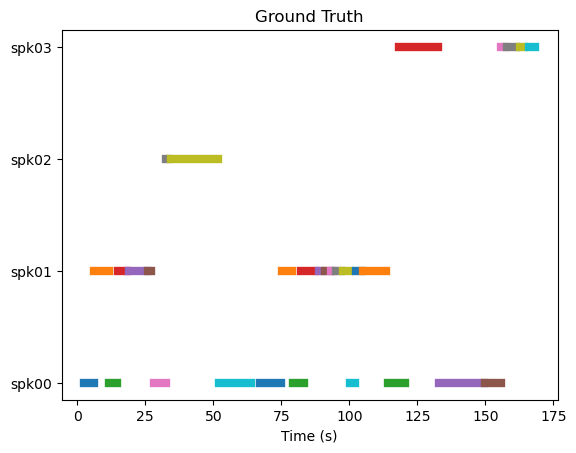

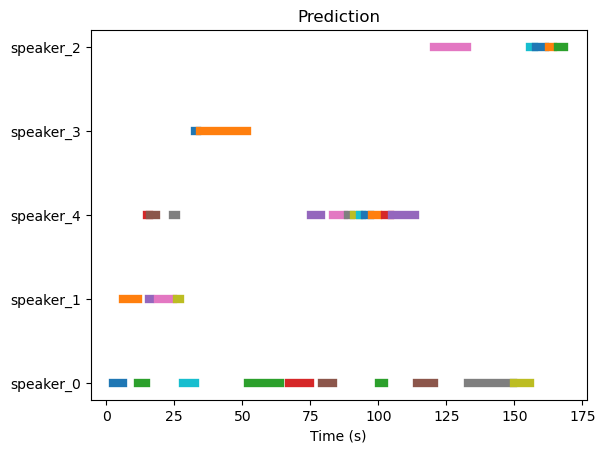

  0%|          | 0/232 [00:00<?, ?it/s]


SystemExit: 1

c:\Users\rakin\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [2]:
# Calculate DER metrics for Oracle VAD

calculate_der_metrics(
    RTTM_TRUTH, RTTM_ORACLE_VAD, os.path.join(RESULTS_DIRECTORY, "der_oracle_vad.csv")
)

# Calculate DER metrics for Oracle Decoder
calculate_der_metrics(
    RTTM_TRUTH, RTTM_ORACLE_DECODER, os.path.join(RESULTS_DIRECTORY, "der_oracle_decoder.csv")
)


# Calculate DER metrics FOR ESCAPA SC
calculate_der_metrics(
    RTTM_TRUTH, RTTM_ESCAPA_SC, os.path.join(RESULTS_DIRECTORY, "der_escapa_sc.csv")
)

# Calculate DER metrics FOR ESCAPA AHC
calculate_der_metrics(
    RTTM_TRUTH, RTTM_ESCAPA_AHC, os.path.join(RESULTS_DIRECTORY, "der_escapa_ahc.csv")
)

# Calculate DER metrics FOR XVECTOR AHC
calculate_der_metrics(
    RTTM_TRUTH, RTTM_XVECTOR_AHC, os.path.join(RESULTS_DIRECTORY, "der_xvector_ahc.csv")
)

# Calculate DER metrics FOR XVECTOR SC
calculate_der_metrics(
    RTTM_TRUTH, RTTM_XVECTOR_SC, os.path.join(RESULTS_DIRECTORY, "der_xvector_sc.csv")
)